Problem Statement : Twitter Sentiment Analysis/Classification/Prediction

In this project, we try to implement an NLP Twitter sentiment analysis model that helps to overcome the challenges of sentiment classification of tweets. We will be classifying the tweets into positive or negative sentiments.


dataset link : https://www.kaggle.com/datasets/kazanova/sentiment140 dataset description:

The dataset provided is the Sentiment140 Dataset which consists of 1,600,000 tweets that have been extracted using the Twitter API. The various columns present in this Twitter data are:

1 . ids: Unique id of the tweet

2 . date: the date of the tweet

3 . flag: It refers to the query. If no such query exists, then it is NO QUERY.

4 . user: It refers to the name of the user that tweeted

5 . text: It refers to the text of the tweet

6 . target: the polarity of the tweet (positive or negative)

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
 82% 66.0M/80.9M [00:00<00:00, 239MB/s]
100% 80.9M/80.9M [00:00<00:00, 238MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/sentiment140.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()


Step-01
IMPORTING OF LIBRARYES & LODING OF DATA FILE

In [4]:
import pandas as pd
import numpy as np
import os
import importlib
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
plt.style.use('default')
warnings.filterwarnings('ignore')

In [5]:
features_name=['target','ids','date','flag','user','text']
df=pd.read_csv('/content/training.1600000.processed.noemoticon.csv',names=features_name,encoding='ISO-8859-1')

In [6]:
#checkout top 5 rows
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
df.duplicated().sum()

0

In [8]:
df.isnull().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


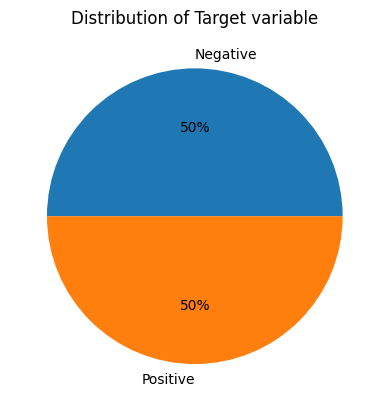

In [10]:
#check the distribution of target variable
plt.pie(df['target'].value_counts(),autopct='%2.f%%',labels=['Negative','Positive'])
plt.title('Distribution of Target variable')
plt.show()


### Our dataset is balanced , it has equal tweets for each class 0-'Negetive' , 4-'Positive'

In [11]:
#check the distribution of flag feature:
df['flag'].value_counts()

flag
NO_QUERY    1600000
Name: count, dtype: int64

# For sentiment analysis of tweets we required only tweet text and target feature so i am dropping all unnecessary features from the dataset.

In [12]:
#For sentiment analysis / prediction of tweets we required only tweet text and target feature,
#So i am taking only these two features and leaving all unnecessary features from the dataset.
df=df[['text','target']]

In [13]:
#Checkout top 5 tweets
df.head()

,text,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


# Data Manipulation

In [14]:
df['target'].value_counts()

target
0    800000
4    800000
Name: count, dtype: int64

### Description about Target variable : 0 == negative and 4 == positive

In [15]:
#lets replace 4 with 1 to make it more convenient
df['target']=df['target'].replace(4,1)

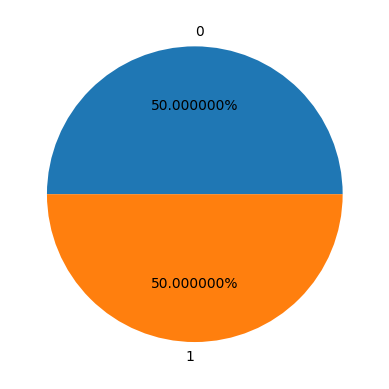

In [16]:
target_counts=df['target'].value_counts()
plt.pie(target_counts.values,autopct='%2f%%',labels=target_counts.index)
plt.show()

In [17]:
df.rename(columns={'text':'tweet'},inplace=True)

In [18]:
df.head()

,tweet,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [19]:
#convert all the tweet text into lower case
df['tweet']=df['tweet'].str.lower()

In [20]:
#as we can see all the tweets are convert into lower case
df.head(5)

,tweet,target
0,"@switchfoot http://twitpic.com/2y1zl - awww, t...",0
1,is upset that he can't update his facebook by ...,0
2,@kenichan i dived many times for the ball. man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


## Now we will do text proccessing using NLTK library

In [21]:
import nltk
#download stopwords and punctuation
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [22]:
# Get the list of english language stopwords from the nltk corpus
from nltk.corpus import stopwords
english_stopwords=stopwords.words('english')
STOPWORDS=set(english_stopwords)

In [23]:
#clean/remove stopwords from the tweets
def clean_stopwords(text):
  value=' '.join(word for word in text.split() if word not in STOPWORDS)
  return value

In [24]:
#apply clean_stopwords function on tweet to remove the stopwords.
df['tweet']=df['tweet'].apply(lambda x: clean_stopwords(x))

In [25]:
import string
english_punctuations=string.punctuation
print(english_punctuations)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [26]:
#clearning and removing punctuations
import string
english_punctuations=string.punctuation

punctuation_list=english_punctuations

def cleaning_punctuations(text):
    translator=str.maketrans('', '',punctuation_list)
    return text.translate(translator)

df["tweet"]=df["tweet"].apply(lambda text: cleaning_punctuations(text))

In [27]:
#check top 10 tweets after stopwords and punctuation removal to make sure we have successfully cleaned the tweet
df.head(10)

,tweet,target
0,switchfoot httptwitpiccom2y1zl awww thats bum...,0
1,upset cant update facebook texting it might cr...,0
2,kenichan dived many times ball managed save 50...,0
3,whole body feels itchy like fire,0
4,nationwideclass no behaving all im mad here ca...,0
5,kwesidei whole crew,0
6,need hug,0
7,loltrish hey long time see yes rains bit only ...,0
8,tatianak nope,0
9,twittera que muera,0


In [28]:
df.shape

(1600000, 2)

In [29]:
import re
#cleaning and removing repeated charecters:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+',r'1',text)

df["tweet"]=df["tweet"].apply(lambda text: cleaning_repeating_char(text))
df.head()

,tweet,target
0,switchfoot httptwitpiccom21zl awww thats bumm...,0
1,upset cant update facebook texting it might cr...,0
2,kenichan dived many times ball managed save 50...,0
3,whole body feels itchy like fire,0
4,nationwideclass no behaving all im mad here ca...,0


In [30]:
#cleaning removing URL from tweet
def cleaning_url(text):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',text)

df["tweet"]=df["tweet"].apply(lambda text: cleaning_url(text))
df.head()

,tweet,target
0,switchfoot httptwitpiccom21zl a s bummer shou...,0
1,upset cant update facebook texting it might cr...,0
2,kenichan dived many times ball managed save 50...,0
3,whole body feels itchy like fire,0
4,nationwideclass no behaving all im mad here ca...,0


In [31]:
#clearning and removing numeric numbers
def cleaning_numbers(text):
    return re.sub('[0-9]+', '',text)

df["tweet"]=df["tweet"].apply(lambda text: cleaning_numbers(text))
df.head()

,tweet,target
0,switchfoot httptwitpiccomzl a s bummer should...,0
1,upset cant update facebook texting it might cr...,0
2,kenichan dived many times ball managed save r...,0
3,whole body feels itchy like fire,0
4,nationwideclass no behaving all im mad here ca...,0


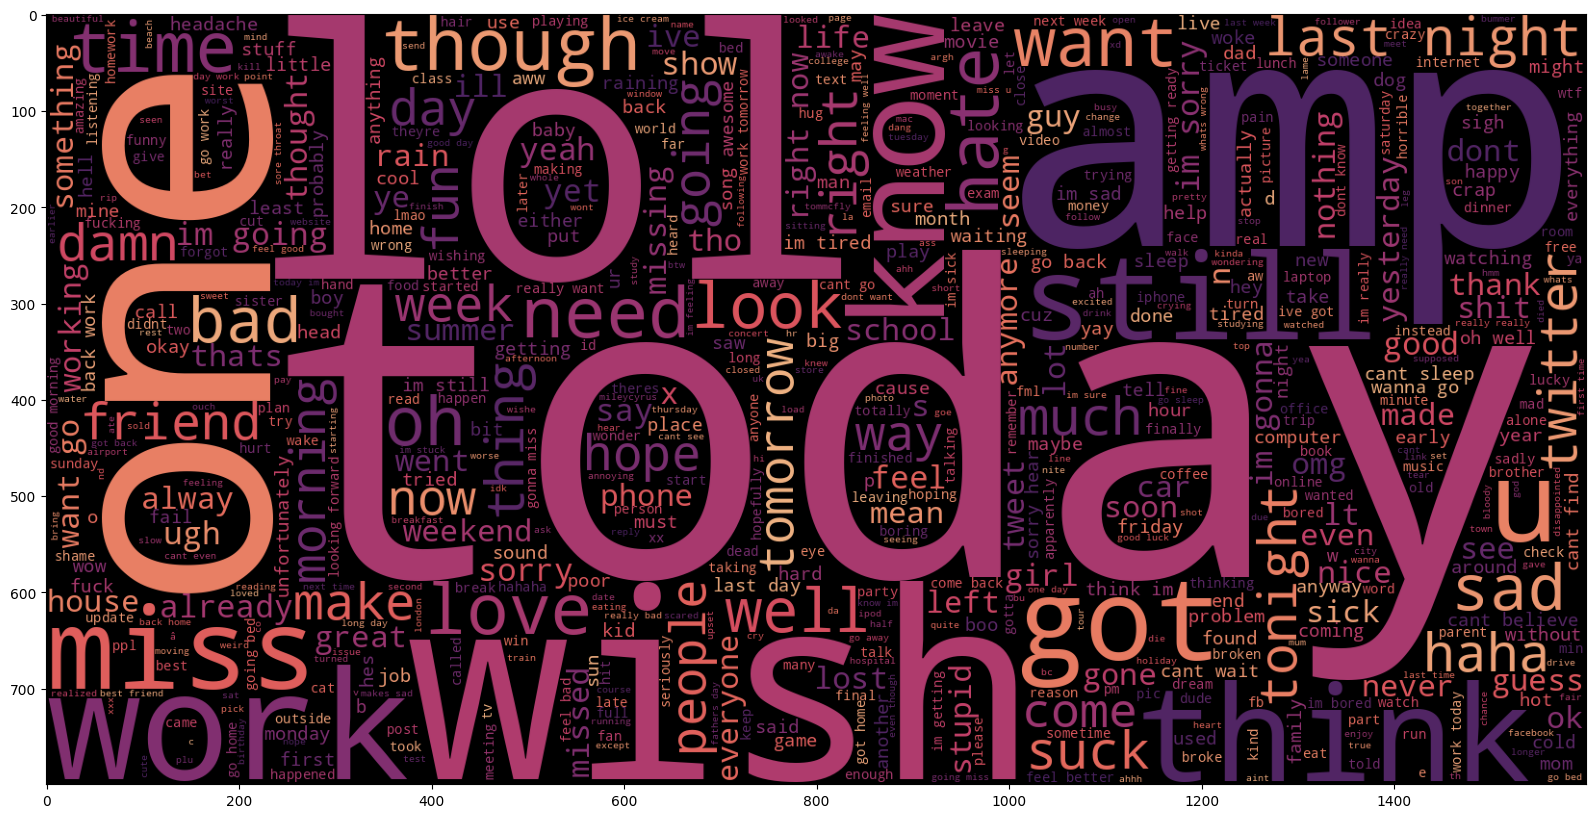

In [32]:
#plot cloud of words for negative class
negative_tweets=df[df["target"]==0]["tweet"]
plt.figure(figsize=(20,10))
from wordcloud import WordCloud

wc= WordCloud(max_words=1000, min_font_size=10, height=800, width=1600, background_color='black', colormap='flare').generate(' '.join(np.array(negative_tweets)))
plt.imshow(wc)
plt.show()

In [33]:
#word tokenization of tweet
from nltk.tokenize import word_tokenize
df["tweet"]=df["tweet"].apply(word_tokenize)
df.head()

,tweet,target
0,"[switchfoot, httptwitpiccomzl, a, s, bummer, s...",0
1,"[upset, cant, update, facebook, texting, it, m...",0
2,"[kenichan, dived, many, times, ball, managed, ...",0
3,"[whole, body, feels, itchy, like, fire]",0
4,"[nationwideclass, no, behaving, all, im, mad, ...",0


In [34]:
# apply lemmatizer on df.
nltk.download('wordnet')
lm=nltk.WordNetLemmatizer()

def lemmatizer_on_word(text):
    data=[lm.lemmatize(word) for word in text]
    return data
df["tweet"]=df["tweet"].apply(lambda text:lemmatizer_on_word(text))
df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...


,tweet,target
0,"[switchfoot, httptwitpiccomzl, a, s, bummer, s...",0
1,"[upset, cant, update, facebook, texting, it, m...",0
2,"[kenichan, dived, many, time, ball, managed, s...",0
3,"[whole, body, feel, itchy, like, fire]",0
4,"[nationwideclass, no, behaving, all, im, mad, ...",0


In [35]:
#remove commma and convert tokens into string before fitting to the model (it's depends on model to model)
df["tweet"]=[" ".join(line)for line in df["tweet"]]

In [36]:
df.head()

,tweet,target
0,switchfoot httptwitpiccomzl a s bummer shoulda...,0
1,upset cant update facebook texting it might cr...,0
2,kenichan dived many time ball managed save res...,0
3,whole body feel itchy like fire,0
4,nationwideclass no behaving all im mad here ca...,0


# Defining of Variable & Targets

In [37]:
X = df.drop(columns = ['target'], axis=1)
y = df['target']

In [38]:
print(X)

                                                     tweet
0        switchfoot httptwitpiccomzl a s bummer shoulda...
1        upset cant update facebook texting it might cr...
2        kenichan dived many time ball managed save res...
3                          whole body feel itchy like fire
4        nationwideclass no behaving all im mad here ca...
...                                                    ...
1599995                   woke up school best feeling ever
1599996  thewdbcom cool hear old walt interview â « ht...
1599997                     ready mojo makeover ask detail
1599998  happy th birthday boo alll time tupac amaru sh...
1599999  happy charitytuesday thenspcc sparkscharity sp...

[1600000 rows x 1 columns]


In [39]:
print(y)

0          0
1          0
2          0
3          0
4          0
          ..
1599995    1
1599996    1
1599997    1
1599998    1
1599999    1
Name: target, Length: 1600000, dtype: int64


### SAMPLING OF DATA

In [40]:
#spliting data into train and test subsets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(df["tweet"],df["target"],test_size=0.2,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((1280000,), (320000,), (1280000,), (320000,))

1. LOGISTIC REGRESSION

In [45]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
lr_model = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("logistic", LogisticRegression(C=1,solver='lbfgs',max_iter=100)) # model the text
])

lr_model.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('logistic', LogisticRegression(C=1))])

In [48]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report,confusion_matrix
#function to make prediction and evaluate the performance of the model.
def predict_and_evaluate_model_performance(model,test_data):
    y_pred=model.predict(test_data)
    print("Training Score : ",model.score(X_train,y_train))
    print("validation Score : ",accuracy_score(y_test,y_pred))
    print("Precision Score : ",precision_score(y_test,y_pred))
    print("Recall Score : ",recall_score(y_test,y_pred))
    print("F1 Score : ",f1_score(y_test,y_pred))
    print("="*100)
    print("Classification Report : ",classification_report(y_test,y_pred))
    print("="*100)
    cm=confusion_matrix(y_test,y_pred)
    print(cm)

In [50]:
#this method takes model and test data as an argument.
predict_and_evaluate_model_performance(lr_model,X_test)

Training Score :  0.81713984375
validation Score :  0.782490625
Precision Score :  0.7736805660093331
Recall Score :  0.8005245909810225
F1 Score :  0.7868737005520836
Classification Report :                precision    recall  f1-score   support

           0       0.79      0.76      0.78    159494
           1       0.77      0.80      0.79    160506

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000

[[121908  37586]
 [ 32017 128489]]


CONCLUSION:- This model is 78% acurate , Hence is an ideal model .

Model 2 : BernoulliNB

In [51]:
from sklearn.naive_bayes import BernoulliNB
nb_model=Pipeline([
        ("tfidf",TfidfVectorizer()),
        ("bernominal",BernoulliNB())
])

nb_model.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('bernominal', BernoulliNB())])

In [52]:
#this method takes model and test data as an argument.
predict_and_evaluate_model_performance(nb_model,X_test)

Training Score :  0.83726640625
validation Score :  0.770828125
Precision Score :  0.7840019808560686
Recall Score :  0.7496292973471397
F1 Score :  0.766430448284099
Classification Report :                precision    recall  f1-score   support

           0       0.76      0.79      0.78    159494
           1       0.78      0.75      0.77    160506

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000

[[126345  33149]
 [ 40186 120320]]


CONCLUSION:- This model is 77% acurate , Hence is an ideal model .

Model 3 : XGBoost

In [53]:
from xgboost import XGBClassifier
xg_model=Pipeline([
        ("tfidf",TfidfVectorizer()),
        ("xgboost",XGBClassifier())
])
xg_model.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('xgboost',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [55]:
#this method takes model and test data as an argument.
predict_and_evaluate_model_performance(xg_model,X_test)

Training Score :  0.741
validation Score :  0.73729375
Precision Score :  0.7009358077913884
Recall Score :  0.8306543057580402
F1 Score :  0.7603017826389444
Classification Report :                precision    recall  f1-score   support

           0       0.79      0.64      0.71    159494
           1       0.70      0.83      0.76    160506

    accuracy                           0.74    320000
   macro avg       0.75      0.74      0.73    320000
weighted avg       0.75      0.74      0.73    320000

[[102609  56885]
 [ 27181 133325]]


CONCLUSION:- This model is 74% acurate , Hence is an ideal model .

CONCLUSION:- Out of the above three model model-01 is the best model.

In [ ]:
*********************************************************DONE******************************************************